# EDS 220 Fall 2021: Visualizing Landsat data using Google Earth Engine

## Introduction to the NDVI

Now that we've gotten somewhat familiar with using Google Earth Engine to do basic data visualizations, in this notebook we'll apply our tools to a new dataset. We'll be working with Landsat data; in case you're curious, the full GEE catalog of Landsat data is available here:

https://developers.google.com/earth-engine/datasets/catalog/landsat

The ultimate goal here is to read in Landsat multispectral data and use it to calculate a standard 'index' product used to indicate vegetation health: the [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index). Here are some example maps showing the surface reflectance sensed by Landsat (left) and the NDVI index calculated from those data (right):

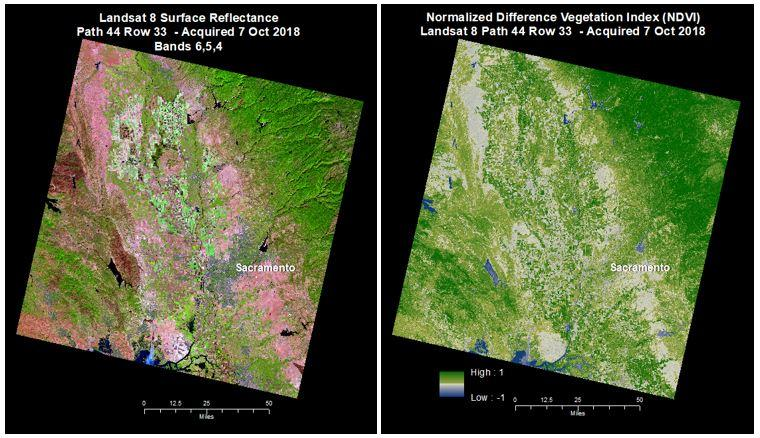

The NDVI is calculated using the red (R) and near-infrared (NIR) bands, combined using the following formula: 

### $NDVI = \frac{(NIR - R)}{(NIR + R)}$

A more detailed description is available on the USGS Landsat website:

https://www.usgs.gov/core-science-systems/nli/landsat/landsat-normalized-difference-vegetation-index?qt-science_support_page_related_con=0#qt-science_support_page_related_con

## Configure your environment

**REMINDER:** the exercises here assume that you've launched Jupyter from within the environment you created to interact with GEE (in the previous notebook, it was called `gee_env`). 

**1. Import required packages**

In [1]:
import ee
import geemap
import pandas as pd

Here I am including the `ee.Authenticate()` and `ee.Initialize()` steps that are discussed in the Homework 1 repository. As a reminder: these are handy if your connection to the GEE API has been idle for a while or got disrupted somehow, since they allow you to re-authenticate (`ee.Authenticate()`) and re-establish your connection with the API server (`ee.Initialize()`):

In [2]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AX4XfWi6MXO3KB8oQNex8zuOLMLc2u4gyqKNi_XoYR_DhNB9nfCGF6Qf-Tc



Successfully saved authorization token.


## Read in Landsat 8 data

Next, we need to actually import data from Landsat. There are multiple Landsat missions which have launched over the years: let's use Landsat 8 here, since it is the most recent dataset available as of this writing. 

Landsat provides information in several processing 'tiers':

   - **Tier 1** data are considered high-quality
   - **Tier 2** data don't pass muster to get into Tier 1
   - **Real-Time (RT)** data haven't been processed into either tier yet
    
A full description of the Landsat data organizational structure in GEE can be found at: https://developers.google.com/earth-engine/guides/landsat

The below example reads in data from:

 - The Landsat 8 mission (LC08)
 - Data Collection 1 (C01); this is the first "official" collection of Landsat data ingested into GEE, which will eventually be superseded by Collection 2 but will be maintained through the end of 2022
 - Tier 1 data (T1), the highest data quality 
 
Note that the data we will be reading in here are _top-of-atmosphere (TOA) reflectances_, estimates of the radiation reflected at the top of Earth's atmosphere.

The first thing we'll do is to read in the Tier 1-Real Time dataset, using the `ee.ImageCollection` function:

The code chunk below also displays some metadata on the Landsat image collection using the `first()` method to extract the first image in the collection, then the `getInfo()` method to display information on the bands and other metadata included in that image. These steps are also described in more detail in the HW1 repo!

In [3]:
gdat = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA')

# show some metadata
testing=gdat.first()
testing.getInfo()

{'type': 'Image',
 'bands': [{'id': 'B1',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [9171, 9161],
   'crs': 'EPSG:32628',
   'crs_transform': [30, 0, 341085, 0, -30, 8807715]},
  {'id': 'B2',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [9171, 9161],
   'crs': 'EPSG:32628',
   'crs_transform': [30, 0, 341085, 0, -30, 8807715]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [9171, 9161],
   'crs': 'EPSG:32628',
   'crs_transform': [30, 0, 341085, 0, -30, 8807715]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [9171, 9161],
   'crs': 'EPSG:32628',
   'crs_transform': [30, 0, 341085, 0, -30, 8807715]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [9171, 9161],
   'crs': 'EPSG:32628',
   'crs_transform': [30, 0, 341085, 0, -30, 8807715]},
  {'id': 'B6',
   'data_type': {'type': 'Pi

The `gdat` object above is now an ImageCollection, which is pretty much exactly what it sounds like: a data structure made up of all of the Landsat 8 Collection 1 Tier 1-Real Time images. As you can imagine, this is a LOT of information!

Let's figure out what's going on with this data a little bit. It's helpful to look at the *metadata* for any new data source; the easiest way to do that in this case is to look at the Web documentation:

https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2#description

Take a look at the URL above; read the data *description* then note the information on *bands* and *properties*. 

- **Bands** The Bands tab will show you the names and wavelengths of the different spectral bands that Landsat 8 is sensing in.
- **Properties** These are other things that are useful to know about any given piece of data: things like the data processing level, estimated cloud cover, and the PATH and ROW of a given scene. (Recall that these are standardized for the Landsat missions, onto a particular lat/lon grid!)

It's not important to understand the details of every band and property; what matters is knowing where to find this information when you do need it!

## Select a Region

Generally speaking, we're not interested in looking at the entire Landsat archive all at once: instead, we usually want to select a portion of the available data corresponding to a region (and often time period) of interest. Because Landsat (and satellite information in general) is created in repeating swaths slicing across the planet, finding only the data which correspond to a particular spatial and temporal region can be a complex task. Luckily, there are various algorithms which will filter Landsat data for us! In the GEE implementation, this is done using `ee.Filter()` and related functions.

Filtering spatially can take several forms. You can:
- **Select a specific point of interest**
- **Define lat/lon bounds for a region of interest**
or
- **Define your own irregular polygon** which could be a shapefile, or any kind of arbitrary shape defined by a set of lat and lon boundary points.

As a first step, let's select a point of interest: say, Santa Barbara. The `ee.Geometry.Point()` method allows us to define a point using lat/lon coordinates, which we can then use to select all the Landsat images which intersect that point.

In [5]:
pt = ee.Geometry.Point([-119.69, 34.42])   # Point corresponding to Santa Barbara, CA

The `ee.filterBounds()` method then allows us to filter the ImageCollection using the point we've just defined.

In [6]:
gdat_filt = gdat.filterBounds(pt)

### Plot all available data within a region

Now we have filtered the Landsat data to contain only those scenes which include Santa Barbara. Now what? Well, maybe we should look at them! GEE will allow you to plot all images within an ImageCollection; this is done by adding the data as a layer, the same way we did for the ERA data earlier.

The below example combines data from multiple *bands* in the ImageCollection, into a "true color" image. We do this by selecting the red (band B4), green (band B3), and blue (band B2) wavelength data, then passing them as *parameters*. By default, GEE will plot these as RGB colors and stretch **(DELETE: what does 'stretch' mean?)** the color range from 0 to 1; you can change this by passing `max` and `min` values to the parameter array below. Here I have used a max value of 0.3, which the GEE developer guides specify as a reasonable max value.

NOTE: the below code will not produce output, and that is ok! It's just creating a data structure with the appropriate visualization information, stored in `visParams`.

In [7]:
visParams = {'bands': ['B4', 'B3', 'B2'],
             'min': 0,
             'max': 0.3
            }

- **Activity**: Play around with different max/min values to see what they do to the appearance of the plot! You can also change the list of bands, or their ordering: this is how "false color" images are constructed, as we'll discuss more in class.

Now we're ready to actually plot things. First, we generate a base map centered on Santa Barbara; note the number after "zoom" below, this tells GEE how closely to zoom in on the center point. Once the base map is generated, the `addLayer` method is used to add our filtered data with the appropriate visual parameters to the map:

In [8]:
Map = geemap.Map(center=[34.42, -119.69], zoom=8)

Map

Map(center=[34.42, -119.69], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [9]:
Map.addLayer(gdat_filt, visParams)

### Sort based on metadata properties

GEE contains powerful sorting functionality, that allows you to easily identify scenes satisfying different criteria. One commonly-used filtering method is identifying the "least cloudy" scene: because clouds often interfere with many of the scientific questions people are interested in, it can be desirable to figure out which scenes are least likely to be contaminated by large cloud cover.

Recall from your perusal of the Landsat 8 metadata that one of the available "properties" is a value called CLOUD_COVER. This is a number that represents the percentage of the scene covered by clouds; applying the `sort` method based on the CLOUD_COVER property then allows us to determine which scene has the smallest fraction of cloud cover. 

The below is a compound command, which takes the filtered Santa Barbara dataset (`gdat_filt`), sorts it based on CLOUD_COVER, then selects the scene falling first in that new ordered list using the `first()` method. 

When you execute this code, it should overwrite the map displayed in your Map widget above!

In [10]:
gdat_leastcloudy = gdat_filt.sort('CLOUD_COVER').first()

Map.addLayer(gdat_leastcloudy, visParams)

### Calculate NDVI

Technically, arithmetic operations in GEE must be performed on individual Image objects - so if you try to add or subtract ImageCollections directly, an error will result (you can try it if you want, and see what I mean!). There are two ways around this:
 1. Filter the ImageCollection down to a single Image, then perform calculations
 2. Use the `map()` function to perform calculations on each image within the collection

Below are examples using both these methods:
 
**Option 1: Filter ImageCollection down to a single Image**
 
Here, we simply calculate the NDVI for our least-cloudy scene identified in the last step.

For NDVI calculation, we want bands 4 (red) and 5 (NIR), which are called "B4" and "B5" respectively.

In order to perform the actual calculation, we need to use the `subtract`, `add`, and `divide` attributes:

In [13]:
red = gdat_leastcloudy.select('B4')
nir = gdat_leastcloudy.select('B5')

ndvi=(nir.subtract(red)).divide((nir.add(red))).rename('NDVI')


Now we define new visualization parameters appropriate for NDVI. As we discussed in class, since this index is based on a difference between bands, it now has a range between -1 and 1.

**Again, this code will result in a layer displayed in the Map window you generated above! There might be a bit of scrolling involved to get back to it.**

In [14]:
ndviParams = {'min': -1, 
              'max': 1, 
              'palette': ['blue', 'white', 'green']
             }

Map.addLayer(ndvi, ndviParams,'NDVI')

**Option 2: Mapping NDVI across an ImageCollection**

The next example uses `map()` so that we can get familiar with how it works. First, we define a function which takes an image as input: it then calculates NDVI and adds it to the image as a new band called "NDVI". Here is the function:

In [15]:
# Function to calculate NDVI for a given input image
def addNDVI(image):
    red = image.select('B4')
    nir = image.select('B5')
    
    ndvi = (nir.subtract(red)).divide((nir.add(red))).rename('NDVI')
    
    return image.addBands(ndvi)

Now we can use this function in the call to "map" and apply it to the entire collection of Santa Barbara images:

In [16]:
gdat_withndvi = gdat_filt.map(addNDVI)

In [42]:
Map = geemap.Map(center=[34.42, -119.69], zoom=8)

Map

Map(center=[34.42, -119.69], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [17]:
ndviParams = {'bands': 'NDVI',
              'min': -1, 
              'max': 1, 
              'palette': ['blue', 'white', 'green']
             }

Map.addLayer(gdat_withndvi, ndviParams)